<a href="https://colab.research.google.com/github/Swapnil-417/Bike-Sharing-Demand-Prediction/blob/main/Bike_Sharing_Demand_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Seoul Bike Sharing Demand Prediction </u></b>

## <b> Problem Description </b>

### Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.


## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing all the required libraries that we will be using.

In [122]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid",{'grid.linestyle': '--'})

import datetime as dt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [6]:
# importing the dataset
directory_path = "/content/drive/MyDrive/Capstone Projects/Bike Sharing Demand Prediction – Swapnil Patil/Data/"
bike_df = pd.read_csv(directory_path + "SeoulBikeData.csv", encoding= 'unicode_escape')

# **Getting to Know about Data**

At the very first, we will start understanding the data.

In [7]:
# first look
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [8]:
bike_df.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


This dataset contains the data of rented bike count in the city of seoul. It presents the count of bikes rented per hour and the weather conditions for the day. The data is of one year from December 2017 to November 2018.

In [9]:
bike_df.shape

(8760, 14)

In [10]:
bike_df.columns= map(str.lower, bike_df.columns)
bike_df.columns

Index(['date', 'rented bike count', 'hour', 'temperature(°c)', 'humidity(%)',
       'wind speed (m/s)', 'visibility (10m)', 'dew point temperature(°c)',
       'solar radiation (mj/m2)', 'rainfall(mm)', 'snowfall (cm)', 'seasons',
       'holiday', 'functioning day'],
      dtype='object')

In [11]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented bike count          8760 non-null   int64  
 2   hour                       8760 non-null   int64  
 3   temperature(°c)            8760 non-null   float64
 4   humidity(%)                8760 non-null   int64  
 5   wind speed (m/s)           8760 non-null   float64
 6   visibility (10m)           8760 non-null   int64  
 7   dew point temperature(°c)  8760 non-null   float64
 8   solar radiation (mj/m2)    8760 non-null   float64
 9   rainfall(mm)               8760 non-null   float64
 10  snowfall (cm)              8760 non-null   float64
 11  seasons                    8760 non-null   object 
 12  holiday                    8760 non-null   object 
 13  functioning day            8760 non-null   objec

In this Dataset, we have 8760 rows and 14 columns from which "rented bike count" is our target variable. There are numerical variables as well as categorical variables and one date variable which is stored as object so we will need to convert its dtype.

In [12]:
# converting dtype of date column
def get_date(date_str):
  date_obj= dt.datetime.strptime(date_str, '%d/%m/%Y')
  date_obj= pd.to_datetime(date_obj.date(), format="%Y-%m-%d")
  return date_obj

bike_df['date'] = bike_df['date'].apply(get_date)

In [13]:
# extracting date, month and day of week
bike_df['day'] = bike_df['date'].apply(lambda x : x.day)
bike_df['month'] = bike_df['date'].apply(lambda x : x.month)
bike_df['day_of_week'] = bike_df['date'].dt.day_name()

bike_df= bike_df.drop("date", axis= 1)

In [14]:
bike_df.head()

,rented bike count,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),dew point temperature(°c),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day,day,month,day_of_week
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,Friday
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,Friday
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,Friday
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,Friday
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,Friday


In [15]:
# checking for duplicate values
bike_df.duplicated().sum()

0

In [16]:
# checking for missing values
bike_df.isnull().sum()

rented bike count            0
hour                         0
temperature(°c)              0
humidity(%)                  0
wind speed (m/s)             0
visibility (10m)             0
dew point temperature(°c)    0
solar radiation (mj/m2)      0
rainfall(mm)                 0
snowfall (cm)                0
seasons                      0
holiday                      0
functioning day              0
day                          0
month                        0
day_of_week                  0
dtype: int64

Above we can see there are no missing values as well as no duplicate values in the dataset.

In [17]:
bike_df.describe(include='all')

,rented bike count,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),dew point temperature(°c),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day,day,month,day_of_week
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760,8760.000000,8760.000000,8760
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2,NaN,NaN,7
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes,NaN,NaN,Friday
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465,NaN,NaN,1272
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN,15.720548,6.526027,NaN
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN,8.796749,3.448048,NaN
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,NaN
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,4.000000,NaN
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN,16.000000,7.000000,NaN
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN,23.000000,10.000000,NaN


# **Exploratory Data Analysis**

## **Univariate Analysis**

### **Dependent Variable**

First we will start with analyzing our target variable which is **rented bike count**.

In [18]:
# dependent variable "rented bike count"
dependent_var= "rented bike count"

In [19]:
bike_df[dependent_var].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: rented bike count, dtype: float64

In [20]:
bike_df[dependent_var].value_counts()

0       295
122      19
223      19
262      19
103      18
       ... 
2379      1
1589      1
1597      1
1605      1
2047      1
Name: rented bike count, Length: 2166, dtype: int64

Now let's see the distribution of our dependent variable 'rented bike count'

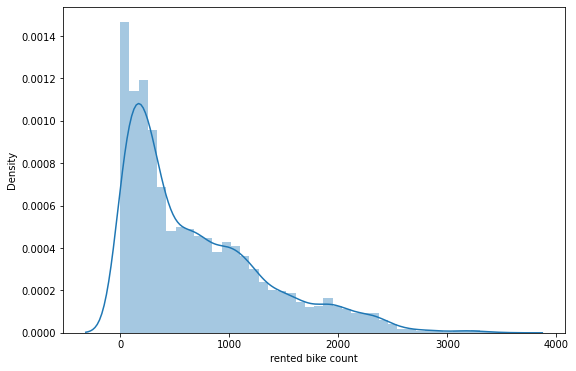

In [21]:
# distribution plot
plt.figure(figsize=(9,6))
sns.distplot(bike_df[dependent_var]);

Dependent variable i.e rented bike count is slightly skewed towards right side (positively skewed). So we will apply transformation and again look at the distribution.

Below are some transformation technique to reduce skewness.

<b>square-root for moderate skew:</b>
sqrt(x) for positively skewed data,
sqrt(max(x+1) - x) for negatively skewed data

<b>log for greater skew:</b>
log10(x) for positively skewed data,
log10(max(x+1) - x) for negatively skewed data

<b>inverse for severe skew:</b>
1/x for positively skewed data
1/(max(x+1) - x) for negatively skewed data


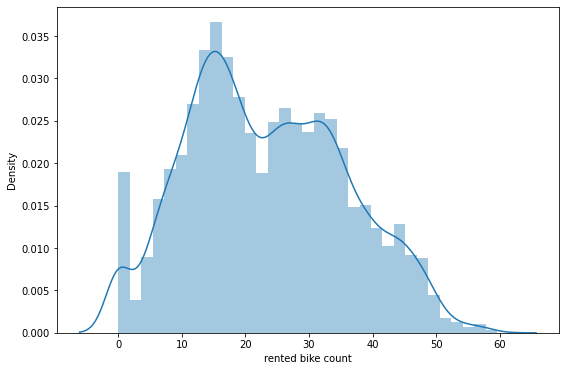

In [22]:
# applying square-root transformation
plt.figure(figsize=(9,6))
sns.distplot(np.sqrt(bike_df[dependent_var]));

It looks good and almost near to normal distribution.



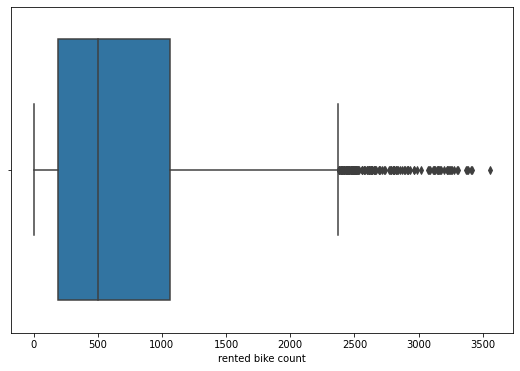

In [23]:
# boxplot 
plt.figure(figsize=(9,6))
sns.boxplot(bike_df[dependent_var]);

From boxplot, we can see the median value of rented bike count is near 500 and there are some outliers towards upper limit.

### **Independent Variables**

### **Numerical Variables**

Now let's have a look at our numerical features and plot some graphs to understand them.

In [24]:
# numerical variables
num_variables= list(bike_df.describe().columns[1:])

In [25]:
num_variables

['hour',
 'temperature(°c)',
 'humidity(%)',
 'wind speed (m/s)',
 'visibility (10m)',
 'dew point temperature(°c)',
 'solar radiation (mj/m2)',
 'rainfall(mm)',
 'snowfall (cm)',
 'day',
 'month']

In [26]:
bike_df[num_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
temperature(°c),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
dew point temperature(°c),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
solar radiation (mj/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80
day,8760.0,15.720548,8.796749,1.0,8.00,16.00,23.00,31.00


In [27]:
# unique count of numerical variables
lst= []
for col in num_variables:
  lst.append(bike_df[col].nunique())

unique_cnt_df= pd.DataFrame(index= num_variables, columns=['unique_count'])
unique_cnt_df['unique_count']= lst
unique_cnt_df

,unique_count
hour,24
temperature(°c),546
humidity(%),90
wind speed (m/s),65
visibility (10m),1789
dew point temperature(°c),556
solar radiation (mj/m2),345
rainfall(mm),61
snowfall (cm),51
day,31


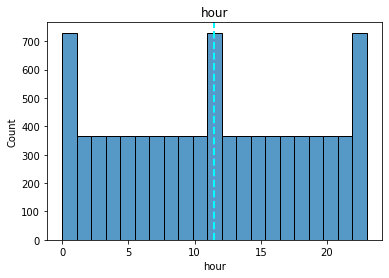

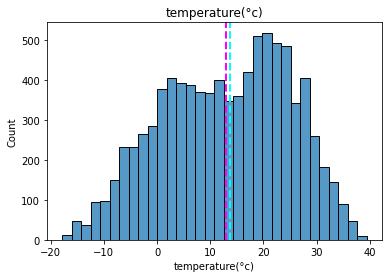

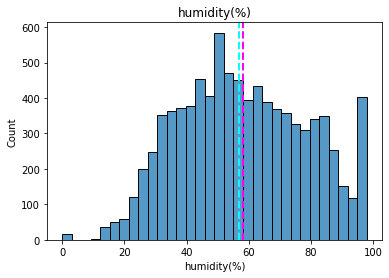

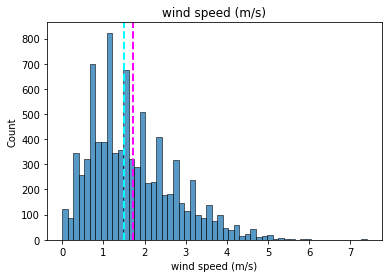

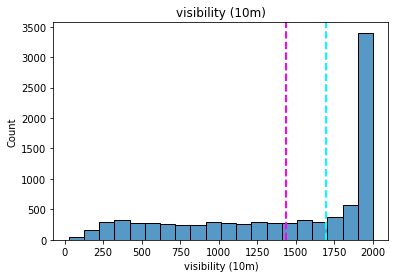

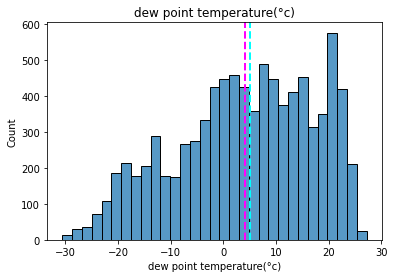

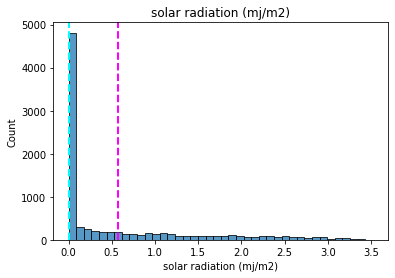

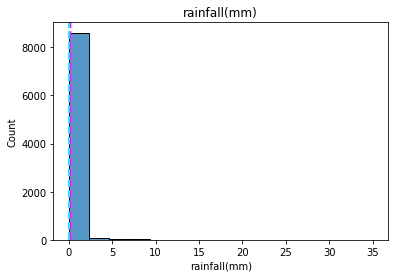

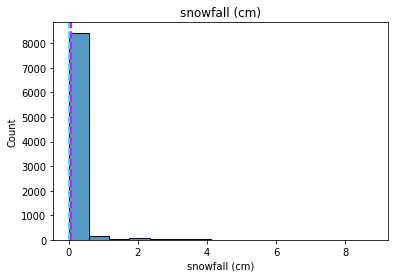

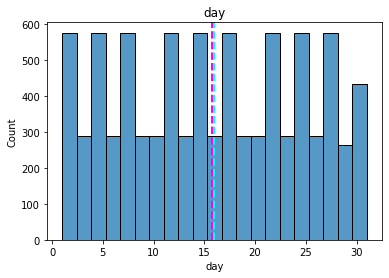

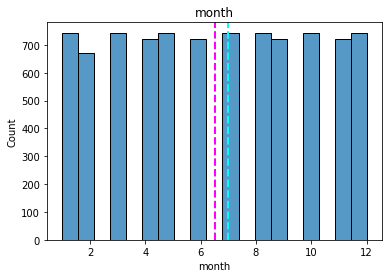

In [28]:
# histogram for each numerical feature count
for col in num_variables:
    feature = bike_df[col]
    sns.histplot(feature)
    plt.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    plt.title(col)
    plt.show()

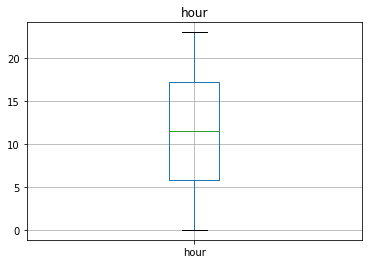

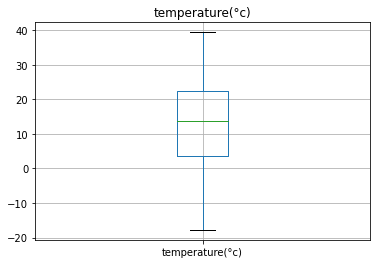

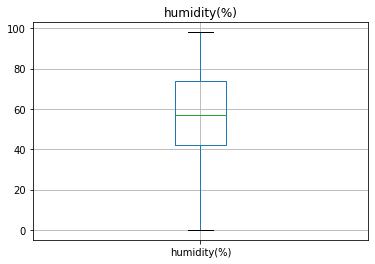

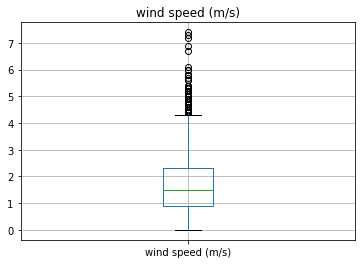

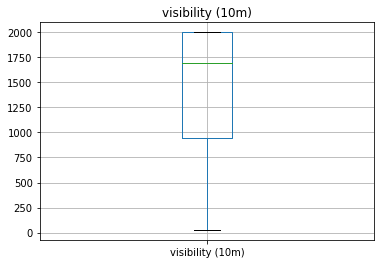

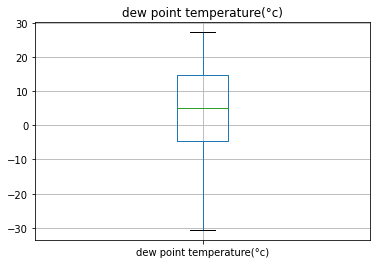

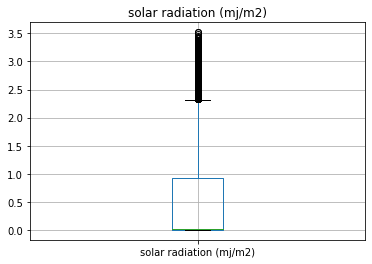

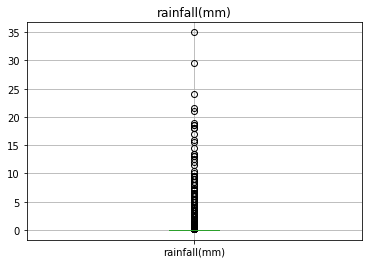

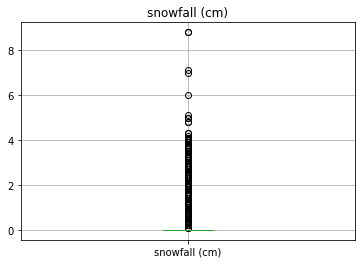

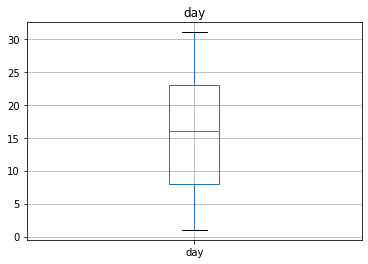

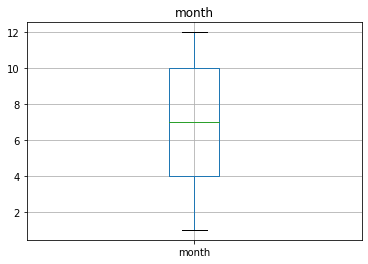

In [29]:
# boxplot for each numerical feature  
for col in num_variables:
    fig = plt.figure()
    ax = fig.gca()
    bike_df.boxplot(col, ax= ax)
    ax.set_title(col)
plt.show()

Variables such as wind speed (m/s), solar radiation (mj/m2), rainfall(mm), snowfall (cm) has outliers as seen in the boxplot.

### **Categorical Variables**

In [39]:
cat_variables= bike_df.select_dtypes(include='object')

Look at the different values of distinct categories in our variables.

In [40]:
# Seasons column
print(f"Count of distinct categories in season variable: {bike_df['seasons'].nunique()}")
print(list(bike_df["seasons"].unique()))

Count of distinct categories in season variable: 4
['Winter', 'Spring', 'Summer', 'Autumn']


In [41]:
# holiday column
print(f"Count of distinct categories in holiday variable: {bike_df['holiday'].nunique()}")
print(list(bike_df["holiday"].unique()))

Count of distinct categories in holiday variable: 2
['No Holiday', 'Holiday']


In [42]:
# functioning day column
print(f"Count of distinct categories in functioning day variable: {bike_df['functioning day'].nunique()}")
print(list(bike_df["functioning day"].unique()))

Count of distinct categories in functioning day variable: 2
['Yes', 'No']


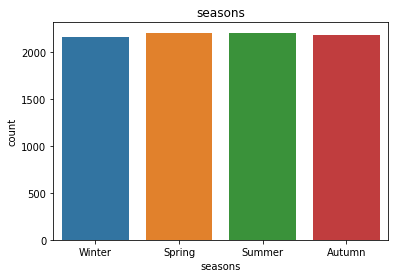

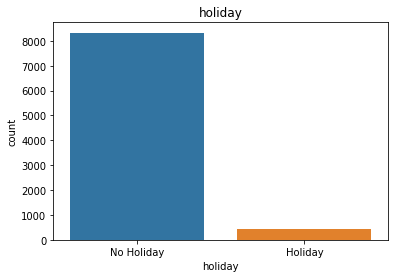

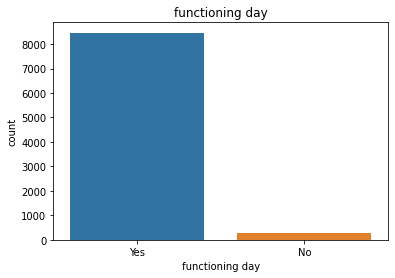

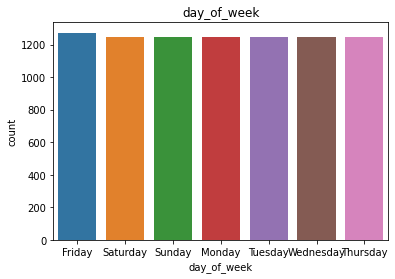

In [43]:
# count plot
for col in cat_variables:
  # plt.figure(figsize=(9,6))
  sns.countplot(data = bike_df, x = col)
  plt.title(col)
  plt.show()

There are very less count of Holiday and No functioning day. We can say that this columns will not have a greater impact.

## **Bivariate Analysis**


### Numerical variables v/s rented bike count

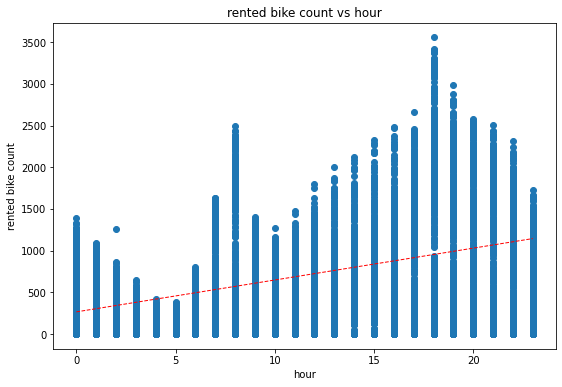

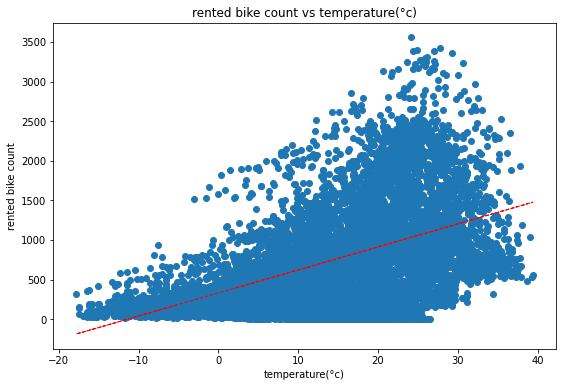

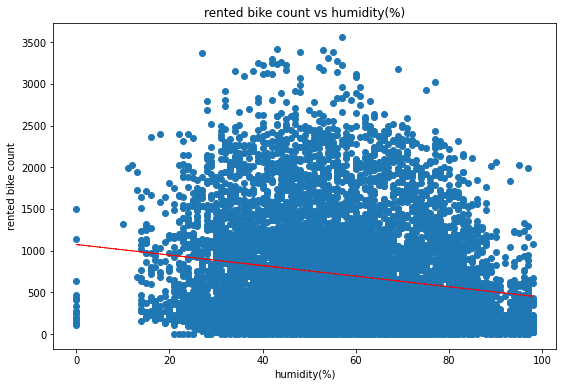

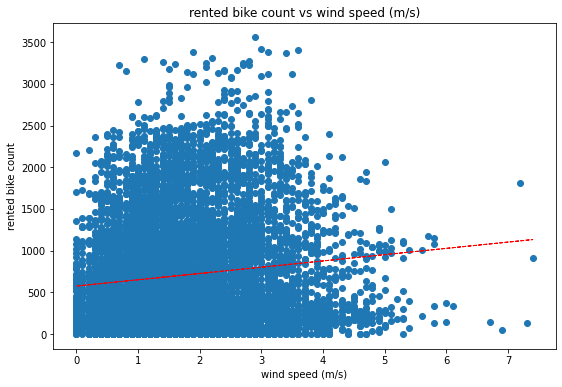

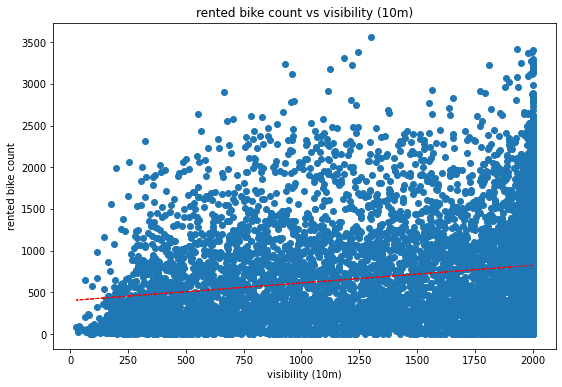

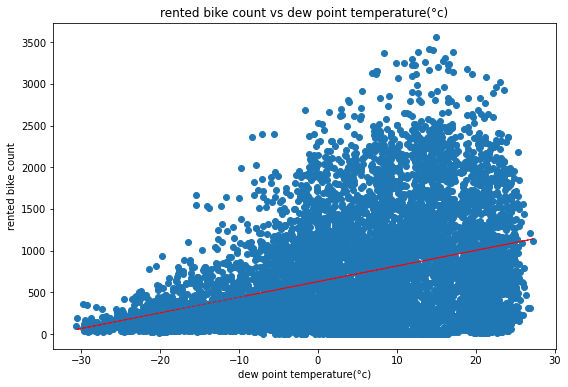

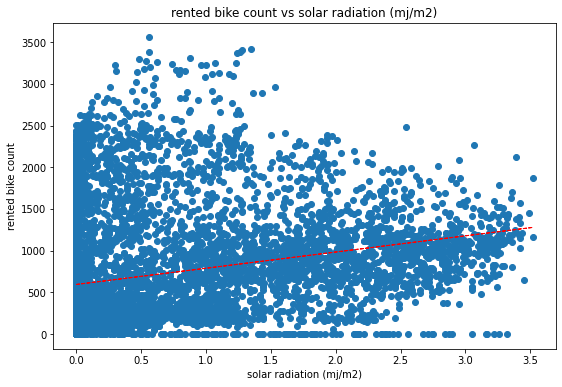

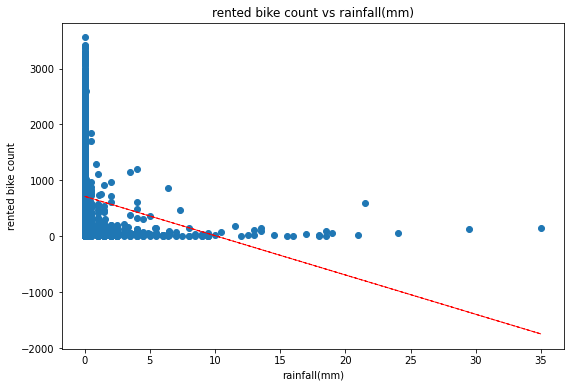

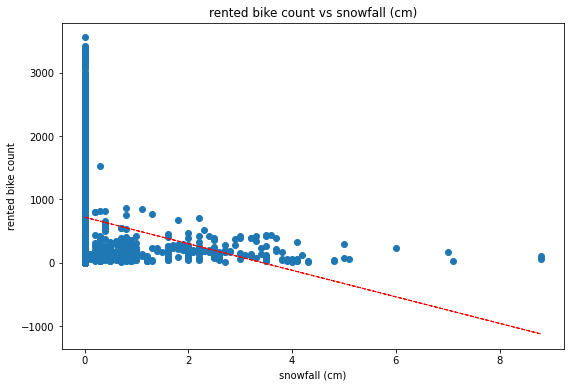

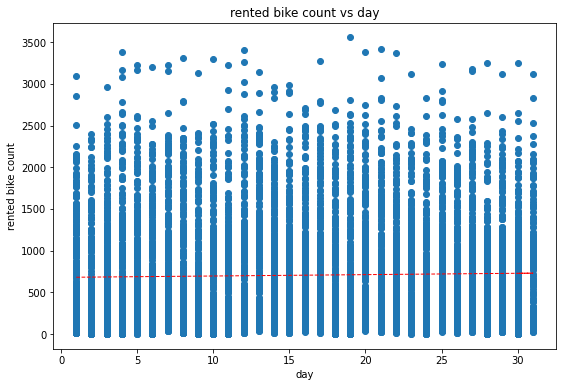

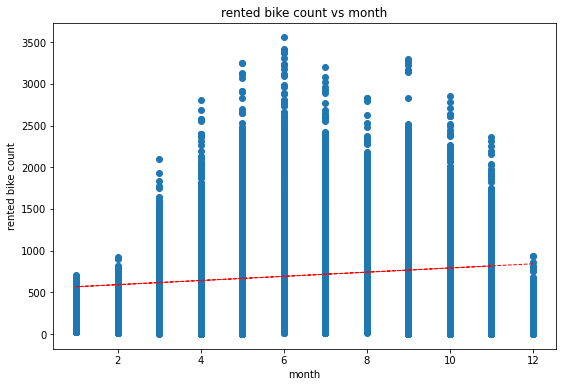

In [37]:
# scatterplot numerical_var v/s rented bike count
for col in num_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_df[col]
    label = bike_df['rented bike count']
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('rented bike count')
    ax.set_title('rented bike count vs ' + col)
    z = np.polyfit(bike_df[col], bike_df['rented bike count'], 1)
    y_hat = np.poly1d(z)(bike_df[col])

    plt.plot(bike_df[col], y_hat, "r--", lw=1)

plt.show()

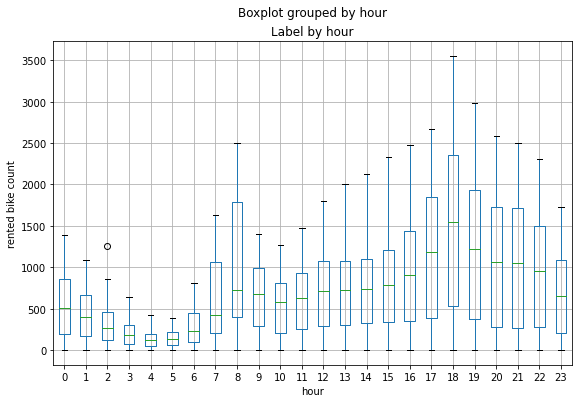

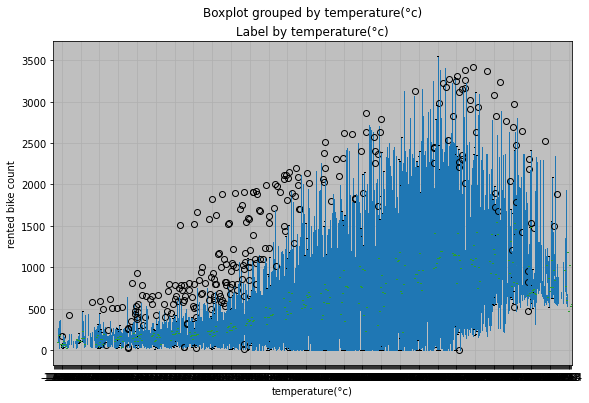

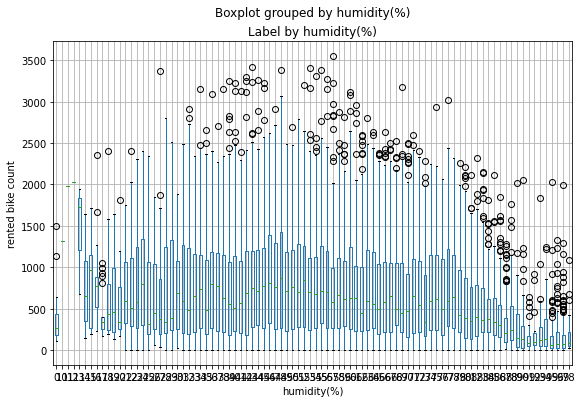

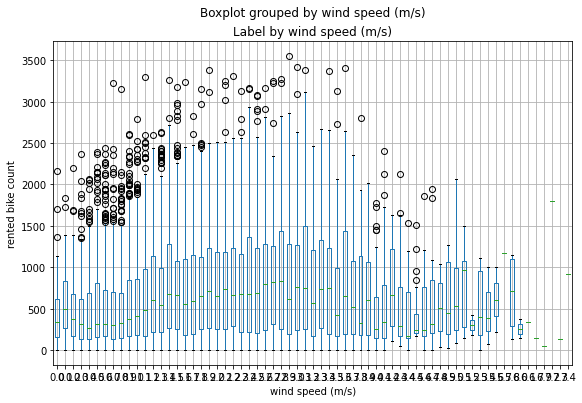

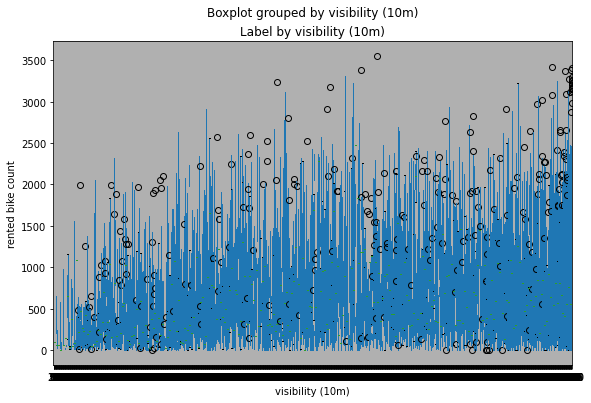

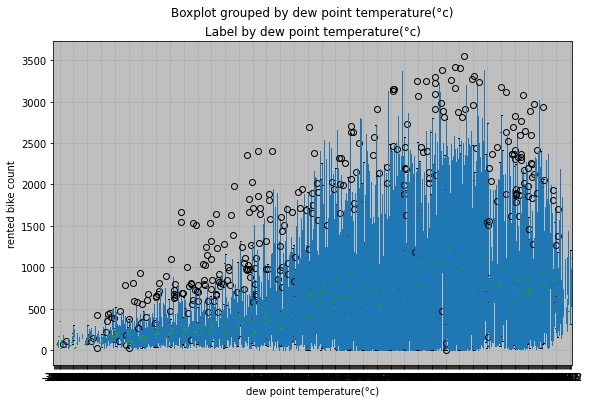

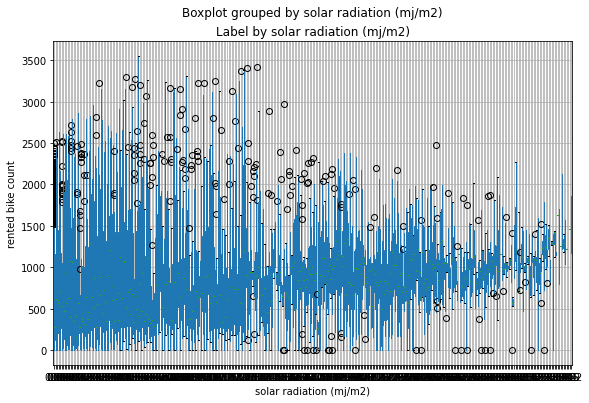

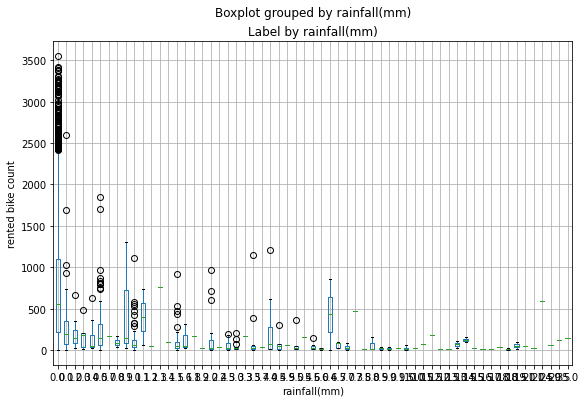

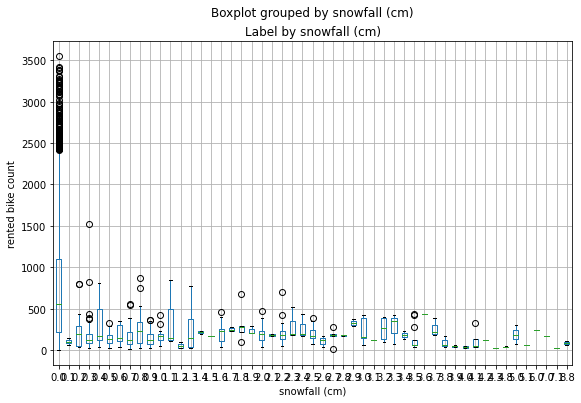

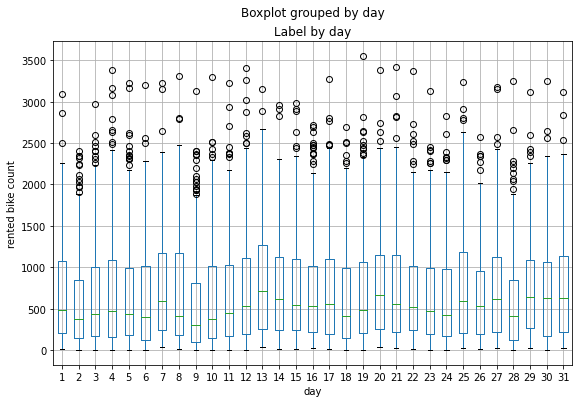

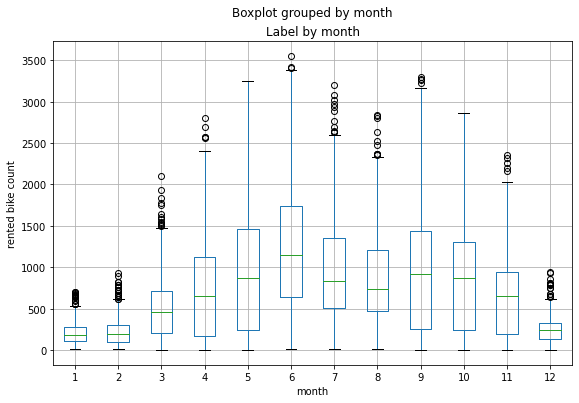

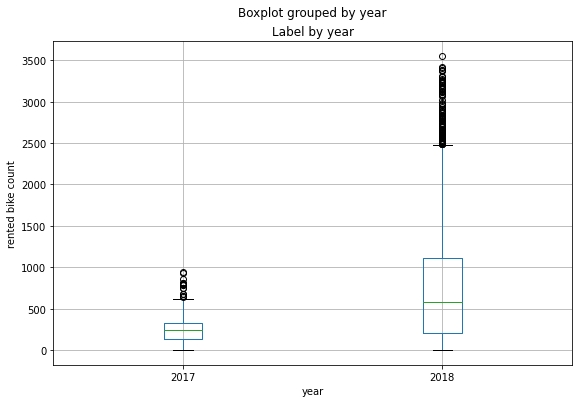

In [34]:
# boxplot numerical_var v/s rented bike count
for col in num_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_df.boxplot(column = 'rented bike count', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("rented bike count")
plt.show()

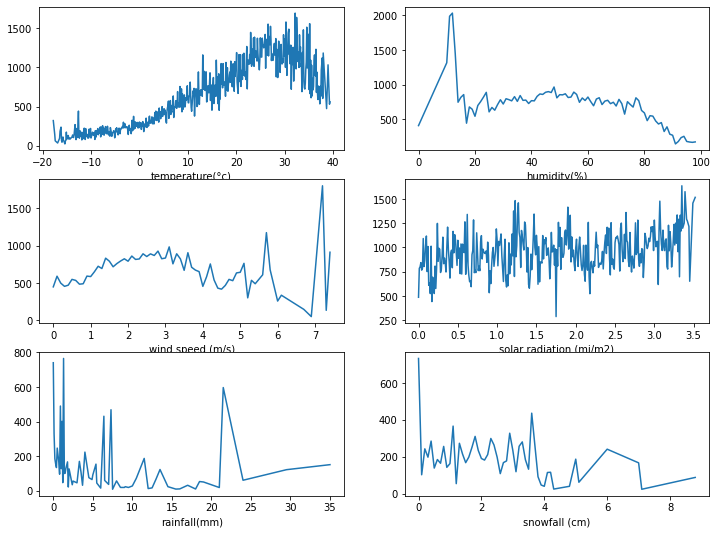

In [35]:
# lineplot numerical_var v/s rented bike count
fig, ax = plt.subplots(3,2,figsize=(12,9))

bike_df.groupby('temperature(°c)').mean()['rented bike count'].plot(ax=ax[0][0])

bike_df.groupby('humidity(%)').mean()['rented bike count'].plot(ax=ax[0][1])

bike_df.groupby('wind speed (m/s)').mean()['rented bike count'].plot(ax=ax[1][0])

bike_df.groupby('solar radiation (mj/m2)').mean()['rented bike count'].plot(ax=ax[1][1])

bike_df.groupby('rainfall(mm)').mean()['rented bike count'].plot(ax=ax[2][0])

bike_df.groupby('snowfall (cm)').mean()['rented bike count'].plot(ax=ax[2][1])

plt.show()

* When the temperature is more the rental bike count is also high. 
* With increase in humidity the demand of rental bikes decreases. 
* Wind speed and solar radiation do not have much impact on the bike count. 
* When there is more than 10mm rainfall the demand of bike decreases but above 20mm of rain there is a huge peak. This could be the outlier or rainfall in the Summer.
* With increase in snowfall there is a decrease in rented bike count.

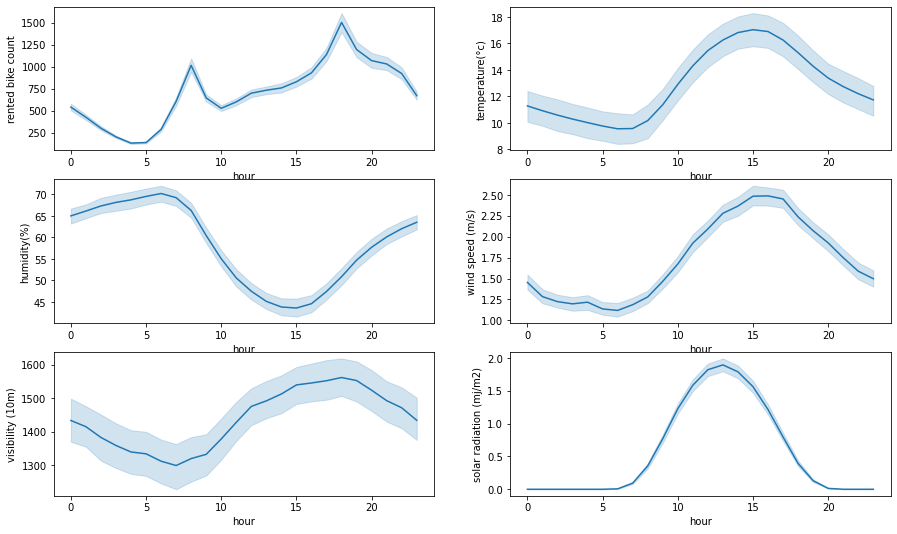

In [36]:
# Analysis of numerical variables during hours
fig, ax = plt.subplots(3,2,figsize=(15,9))

sns.lineplot('hour', 'rented bike count', data=bike_df, ax=ax[0][0])

sns.lineplot('hour', 'temperature(°c)', data=bike_df, ax=ax[0][1])

sns.lineplot('hour', 'humidity(%)', data=bike_df, ax=ax[1][0])

sns.lineplot('hour', 'wind speed (m/s)', data=bike_df, ax=ax[1][1])

sns.lineplot('hour', 'visibility (10m)', data=bike_df, ax=ax[2][0])

sns.lineplot('hour', 'solar radiation (mj/m2)', data=bike_df, ax=ax[2][1])

plt.show()

* At the beginning of the day the demand of rental bike increases with the highest peak in the evening and later decreasing.
* The demand of rental bike in at peak at 8am and 6pm so we can say that demand is more during office opening and closing time.
* Temperature, wind speed, solar radiation also increases and are at the peak in afternoon.

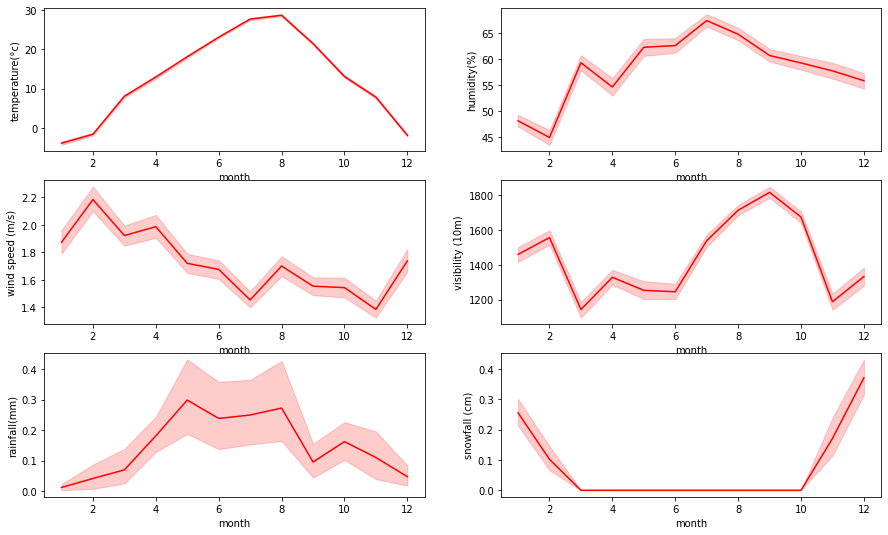

In [37]:
# Analysis of numerical variables across months
fig, ax = plt.subplots(3,2,figsize=(15,9))

sns.lineplot('month', 'temperature(°c)', data=bike_df, color='r', ax=ax[0][0])

sns.lineplot('month', 'humidity(%)', data=bike_df, color='r', ax=ax[0][1])

sns.lineplot('month', 'wind speed (m/s)', data=bike_df, color='r', ax=ax[1][0])

sns.lineplot('month', 'visibility (10m)', data=bike_df, color='r', ax=ax[1][1])

sns.lineplot('month', 'rainfall(mm)', data=bike_df, color='r', ax=ax[2][0])

sns.lineplot('month', 'snowfall (cm)', data=bike_df, color='r', ax=ax[2][1])

plt.show()

### Categorical Variables v/s rented bike count

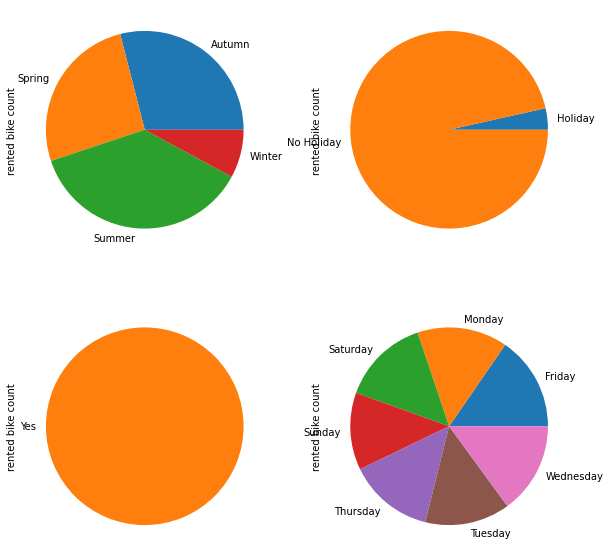

In [47]:
# pie chart Categorical Variables v/s rented bike count
fig, ax = plt.subplots(2,2,figsize=(10,10))

bike_df.groupby('seasons').sum()['rented bike count'].plot.pie(ax= ax[0][0])

bike_df.groupby('holiday').sum()['rented bike count'].plot.pie(ax= ax[0][1])

bike_df.groupby('functioning day').sum()['rented bike count'].plot.pie(ax= ax[1][0])

bike_df.groupby('day_of_week').sum()['rented bike count'].plot.pie(ax= ax[1][1])

plt.show()

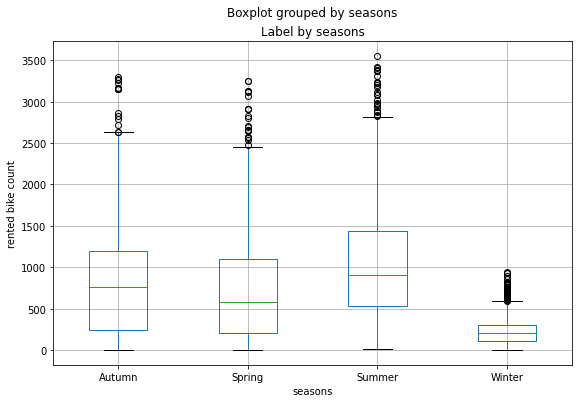

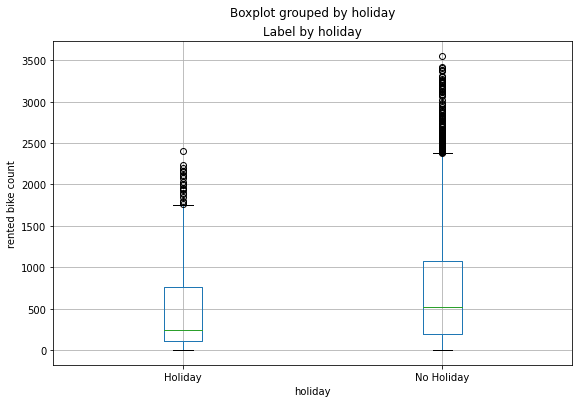

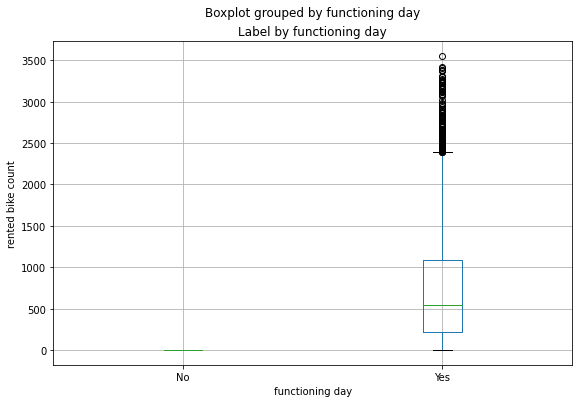

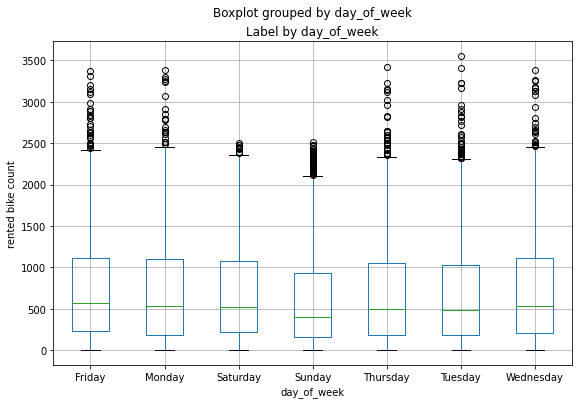

In [48]:
# boxplot categorical_var v/s rented bike count
for col in cat_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_df.boxplot(column = 'rented bike count', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("rented bike count")
plt.show()

* In Summer the demand of rented bike is high because temperature and solar radiation is high in summer. 
* We have seen there are less holidays so obviously rented bike count is also less on holidays. 
* Almost no demand on non functioning day.
* The demand of rental bikes slightly decreases on weekend days i.e saturday and sunday.

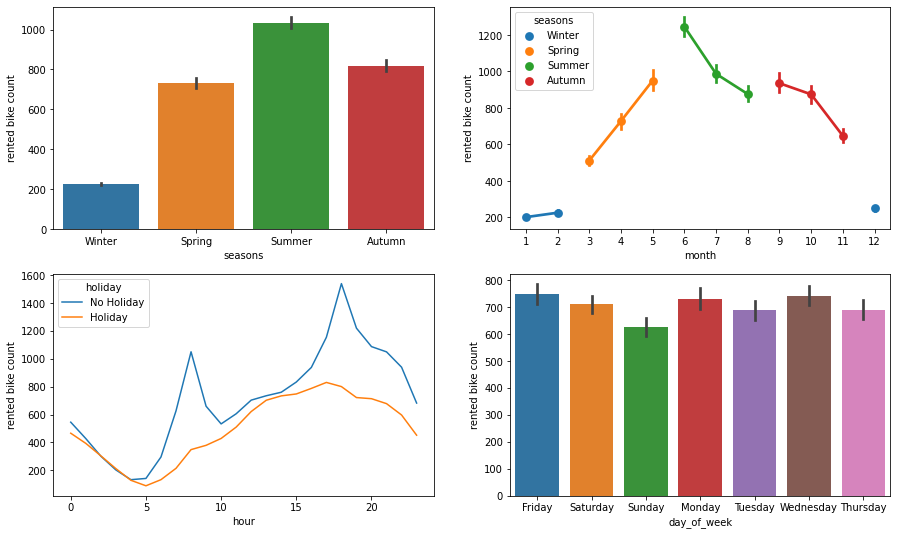

In [54]:
# Analysis of rented bike count on hour, day and monthly basis
fig, ax = plt.subplots(2,2,figsize=(15,9))

sns.barplot(x= 'seasons', y= dependent_var, data= bike_df, ax= ax[0][0])

sns.pointplot(x= 'month', y= dependent_var, hue= 'seasons',
              data= bike_df, ax= ax[0][1])

sns.lineplot(x= 'hour', y= dependent_var, hue= 'holiday',
             ci=None, data= bike_df, ax= ax[1][0])

sns.barplot(x= 'day_of_week', y= dependent_var, data= bike_df, ax= ax[1][1])

plt.show()

* There is a huge demand of bike rents in summer season while the least bike rents occur in winter.
* We can see there is a high demand of rented bike in the month of June, August and less demand in the month of December, January and February i.e winter season.
* Non holidays has comparatively high demand of rented bike as compared to holidays. 
* There is a high demand of rented bikes during office days and demand decreases slightly on Sunday.


# **Feature Selection**

### **Correlation**

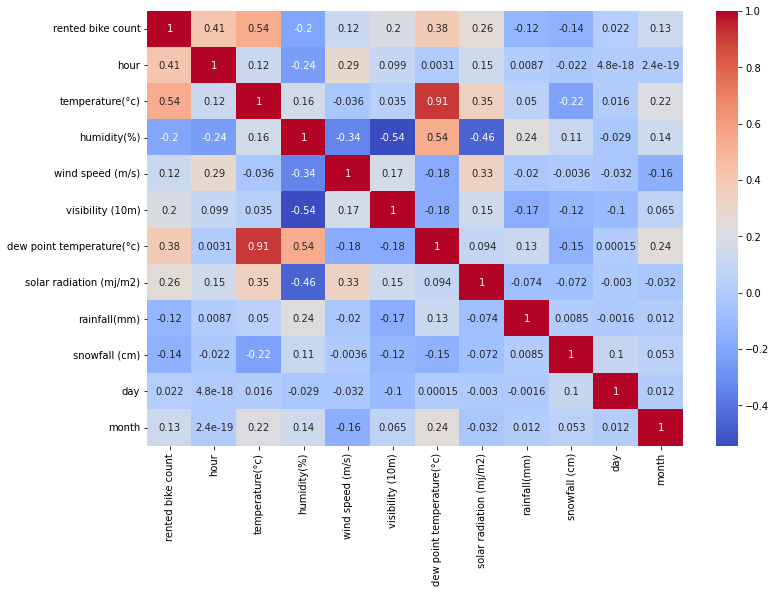

In [55]:
corr_df= bike_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True, cmap= 'coolwarm');

The most correlated features to the rented bike count are:
* hour
* temperature
* dew point temperature
* solar radiation

There is a high correlation between dew point temperature and temperature.

### **Detecting Multicollinearity using VIF**

In [56]:
#Multicollinearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [57]:
calc_vif(bike_df[[i for i in num_variables]])

,variables,VIF
0,hour,4.425960
1,temperature(°c),38.389623
2,humidity(%),8.344305
3,wind speed (m/s),4.879565
4,visibility (10m),9.481423
5,dew point temperature(°c),19.815223
6,solar radiation (mj/m2),2.900819
7,rainfall(mm),1.082134
8,snowfall (cm),1.144168
9,day,4.292003


We can see here that 'dew point temperature(°c)', 'temperature(°c)' have a high VIF value, meaning they can be predicted by other independent variables in the dataset.

Dropping one of the correlated features will help in bringing down the multicollinearity between correlated features.

In [64]:
# droping 'dew point temperature(°c)', 'year', 'day', 'month'
calc_vif(bike_df[[i for i in num_variables if i not in ['dew point temperature(°c)', 'day', 'month']]])

,variables,VIF
0,hour,3.921832
1,temperature(°c),3.228318
2,humidity(%),4.868221
3,wind speed (m/s),4.608625
4,visibility (10m),4.710170
5,solar radiation (mj/m2),2.246791
6,rainfall(mm),1.079158
7,snowfall (cm),1.120579


After droping 'dew point temperature(°c)', 'year', 'day' and 'month', VIF values for all features have decreased less than 5 that is good to build regression model.

In [60]:
# droping 'dew point temperature(°c)', 'year', 'day', 'month' from original dataset
dataset= bike_df.drop(['dew point temperature(°c)', 'day', 'month'], axis=1)

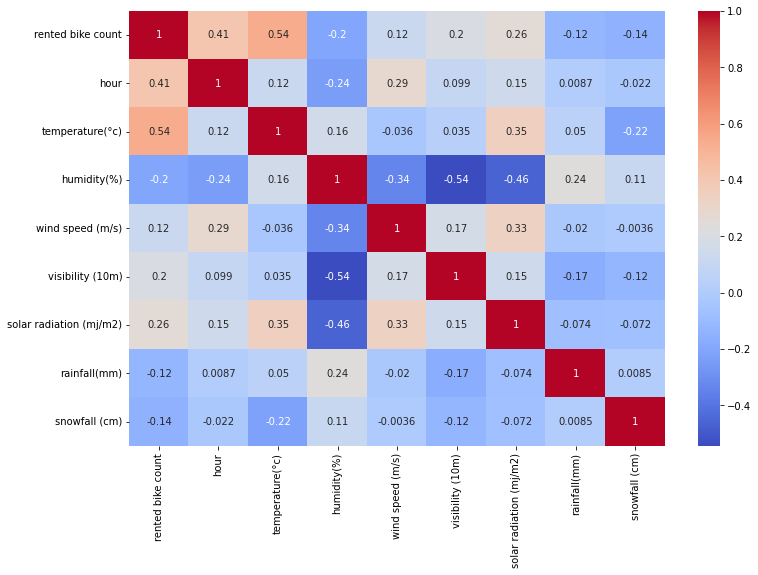

In [61]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset.corr(), annot=True, cmap= 'coolwarm');

## **Feature Engineering**




In [65]:
# creating column of weekend or not
dataset['weekend']= dataset['day_of_week'].apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)
dataset.drop('day_of_week', axis=1, inplace=True)

In [66]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_en = LabelEncoder()

dataset[['seasons','holiday','functioning day']] = dataset[['seasons','holiday','functioning day']].apply(label_en.fit_transform)

In [67]:
dataset.head()

,rented bike count,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day,day_of_week,weekend
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,3,1,1,Friday,0
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,3,1,1,Friday,0
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,3,1,1,Friday,0
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,3,1,1,Friday,0
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,3,1,1,Friday,0


### **Data Preparation**

In [105]:
X= dataset.drop(dependent_var, axis=1)
y= np.sqrt(dataset[dependent_var])

In [106]:
X.head()

,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day,weekend
0,0,-5.2,37,2.2,2000,0.0,0.0,0.0,3,1,1,0
1,1,-5.5,38,0.8,2000,0.0,0.0,0.0,3,1,1,0
2,2,-6.0,39,1.0,2000,0.0,0.0,0.0,3,1,1,0
3,3,-6.2,40,0.9,2000,0.0,0.0,0.0,3,1,1,0
4,4,-6.0,36,2.3,2000,0.0,0.0,0.0,3,1,1,0


In [107]:
y.head()

0    15.937377
1    14.282857
2    13.152946
3    10.344080
4     8.831761
Name: rented bike count, dtype: float64

In [108]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# # transform data
# X = scaler.fit_transform(X)

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [110]:
print(X_train.shape, y_train.shape)

(6132, 12) (6132,)


In [111]:
print(X_test.shape, y_test.shape)

(2628, 12) (2628,)


# **Linear Regression**

In [112]:
# create an instance of linear regression
lin_reg = LinearRegression()

# fitting Linear Regression model
lin_reg.fit(X_train, y_train)

LinearRegression()

In [113]:
# model score
lin_reg.score(X_train, y_train)

0.6540967727241054

In [114]:
lin_reg.coef_

array([ 4.78038514e-01,  5.56795645e-01, -1.57744402e-01,  4.32489954e-02,
        4.02047244e-04, -9.92946769e-01, -1.53370616e+00,  1.57364803e-01,
       -2.13910221e+00,  3.42660904e+00,  2.88459521e+01, -1.45660899e+00])

In [115]:
lin_reg.intercept_

-7.367857457543842

In [116]:
# predictions on train and test data
train_pred_lr= lin_reg.predict(X_train)
test_pred_lr= lin_reg.predict(X_test)

### **Evaluation Metrics**

Creating funtion to calculate evaluation metrics

In [117]:
def evaluation_metrics(y_true, y_pred):

  ''' takes actual target values and estimated target values as input
      and returns evaluation metrics as output '''

  MSE  = mean_squared_error(y_true, y_pred)
  print("MSE :" , MSE)
  RMSE = np.sqrt(MSE)
  print("RMSE :" ,RMSE)
  MAE= mean_absolute_error(y_true, y_pred)
  print("MAE :",MAE)
  print(" ")
  r2 = r2_score(y_true, y_pred)
  print("R2 :" ,r2)
  print("Adjusted R2 : ",1-(1-r2_score(y_true, y_pred))*
        ((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))


In [118]:
# Train data evaluation metrics
evaluation_metrics(y_train, train_pred_lr)

MSE : 53.80611459663623
RMSE : 7.335265134719823
MAE : 5.63805172995284
 
R2 : 0.6540967727241054
Adjusted R2 :  0.65250945389913


In [119]:
# Test data evaluation metrics
evaluation_metrics(y_test, test_pred_lr)

MSE : 53.740491144516426
RMSE : 7.330790622062291
MAE : 5.661287586240897
 
R2 : 0.6501226505752834
Adjusted R2 :  0.6485170948609061


In [120]:
# create test result dict
test_result= {}
test_result["Linear Regression"] = [0.6540967727241054,53.740491144516426,7.330790622062291,0.6501226505752834,0.6485170948609061]

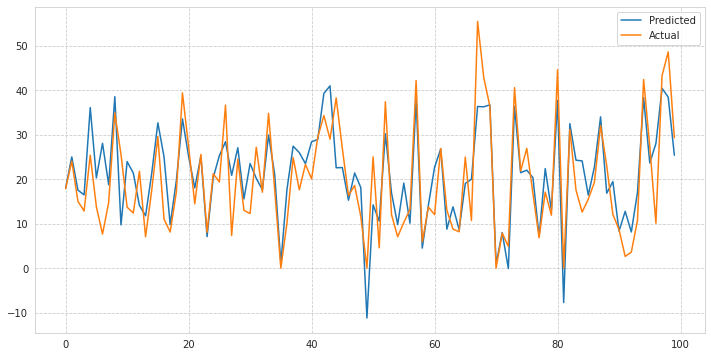

In [123]:
# line graph of actual and predicted values
plt.figure(figsize=(12,6))
plt.plot(test_pred_lr[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

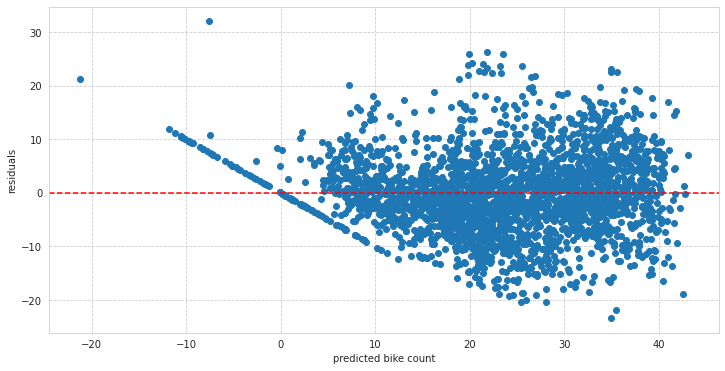

In [124]:
#Heteroskedasticity
plt.figure(figsize=(12,6))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_lr, y_test- test_pred_lr)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

# **Lasso Regression**

In [125]:
from sklearn.linear_model import Lasso

In [126]:
# Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]})

In [127]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)

The best fit alpha value is found out to be : {'alpha': 0.0001}


In [128]:
lasso_regressor.score(X_train, y_train)

0.6540967679051862

In [129]:
# predictions on train and test dataset
train_pred_lasso = lasso_regressor.predict(X_train)
test_pred_lasso= lasso_regressor.predict(X_test)

### **Evaluation Metrics**

In [130]:
# Train data evaluation metrics
evaluation_metrics(y_train, train_pred_lasso)

MSE : 53.80611534623119
RMSE : 7.3352651858151106
MAE : 5.63804777968967
 
R2 : 0.6540967679051862
Adjusted R2 :  0.6525094490580972


In [131]:
# Test data evaluation metrics
evaluation_metrics(y_test, test_pred_lasso)

MSE : 53.74016699398597
RMSE : 7.330768513190549
MAE : 5.661284867852185
 
R2 : 0.6501247609565992
Adjusted R2 :  0.6485192149265722


In [132]:
# appending test results
test_result['Lasso Regression']= [0.6540967679051862, 53.74016699398597, 7.330768513190549, 0.6501247609565992, 0.6485192149265722]

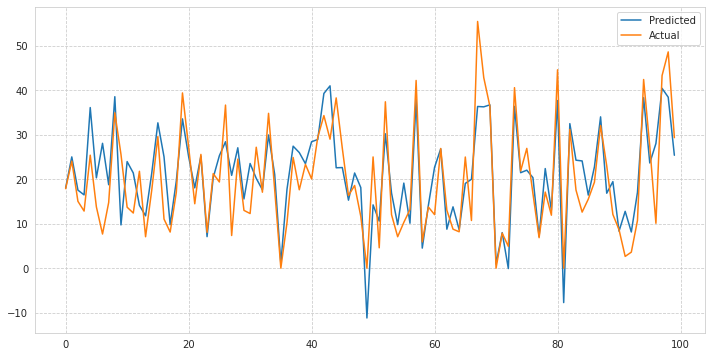

In [133]:
plt.figure(figsize=(12,6))
plt.plot(test_pred_lasso[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

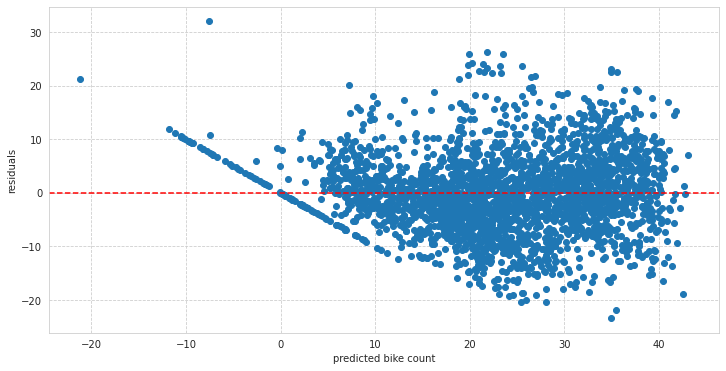

In [134]:
# Heteroskedasticity
plt.figure(figsize=(12,6))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_lasso, y_test- test_pred_lasso)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

# **Ridge regression**

In [135]:
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100,1e-15]}
ridge_reg = GridSearchCV(ridge, parameters, cv=5)
ridge_reg.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100, 1e-15]})

In [136]:
print("The best fit alpha value is found out to be :" ,ridge_reg.best_params_)

The best fit alpha value is found out to be : {'alpha': 1e-15}


In [137]:
ridge_reg.score(X_train,y_train)

0.6540967727241054

In [138]:
# predictions on train and test dataset
train_pred_ridge = ridge_reg.predict(X_train)
test_pred_ridge= ridge_reg.predict(X_test)

### **Evaluation Metrics**

In [139]:
# Train data evaluation metrics
evaluation_metrics(y_train, train_pred_ridge)

MSE : 53.80611459663623
RMSE : 7.335265134719823
MAE : 5.638051729952843
 
R2 : 0.6540967727241054
Adjusted R2 :  0.65250945389913


In [140]:
# Test data evaluation metrics
evaluation_metrics(y_test, test_pred_ridge)

MSE : 53.740491144516426
RMSE : 7.330790622062291
MAE : 5.661287586240899
 
R2 : 0.6501226505752834
Adjusted R2 :  0.6485170948609061


In [141]:
# appending test results
test_result['Ridge Regression']= [0.6540967727241054, 53.740491144516426, 7.330790622062291, 0.6501226505752834, 0.6485170948609061]

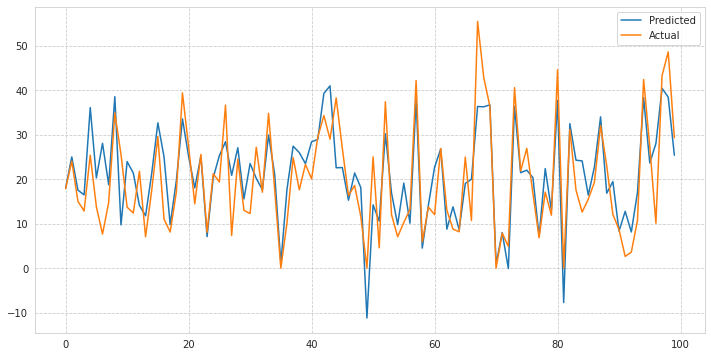

In [142]:
plt.figure(figsize=(12,6))
plt.plot(test_pred_ridge[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

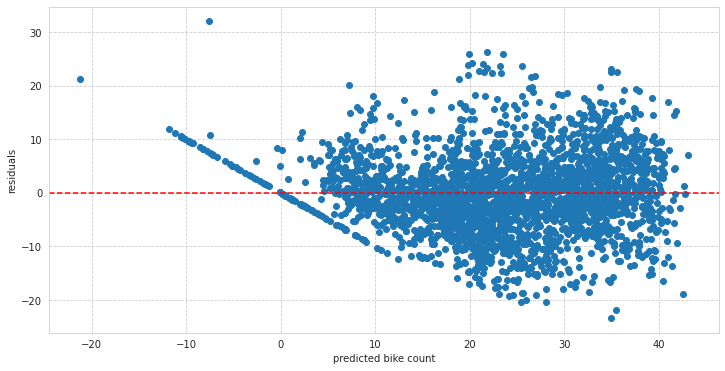

In [143]:
# Heteroskedasticity
plt.figure(figsize=(12,6))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_ridge, y_test- test_pred_ridge)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

# **Elastic Net Regression**

In [144]:
from sklearn.linear_model import ElasticNet

In [148]:
# parameters
en_param = {'alpha': [1e-15,1e-10,1e-5,1e-3,1e-2,1e-1,1,5,10,20,30,40,50,100],
              'l1_ratio':[0.1,0.2,0.3,0.4,0.5]
              }

In [149]:
# create an instance
elasticnet = ElasticNet()

en_grid= GridSearchCV(elasticnet, en_param, cv= 5)
en_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.01, 0.1, 1, 5,
                                   10, 20, 30, 40, 50, 100],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5]})

In [150]:
en_grid.best_params_

{'alpha': 1e-15, 'l1_ratio': 0.2}

In [152]:
en_model= en_grid.best_estimator_

In [153]:
# Model score
en_model.score(X_train,y_train)

0.6540967727241054

In [154]:
# predictions on train and test data
train_pred_en= en_model.predict(X_train)
test_pred_en= en_model.predict(X_test)

### **Evaluation Metrics**

In [155]:
# Train data evaluation metrics
evaluation_metrics(y_train, train_pred_en)

MSE : 53.80611459663623
RMSE : 7.335265134719823
MAE : 5.638051729952843
 
R2 : 0.6540967727241054
Adjusted R2 :  0.65250945389913


In [156]:
# Test data evaluation metrics
evaluation_metrics(y_test, test_pred_en)

MSE : 53.740491144516405
RMSE : 7.330790622062289
MAE : 5.661287586240901
 
R2 : 0.6501226505752835
Adjusted R2 :  0.6485170948609063


In [157]:
# appending test results
test_result['ElasticNet Regression']= [0.6540967727241054, 53.740491144516405, 7.330790622062289, 0.6501226505752835, 0.6485170948609063]

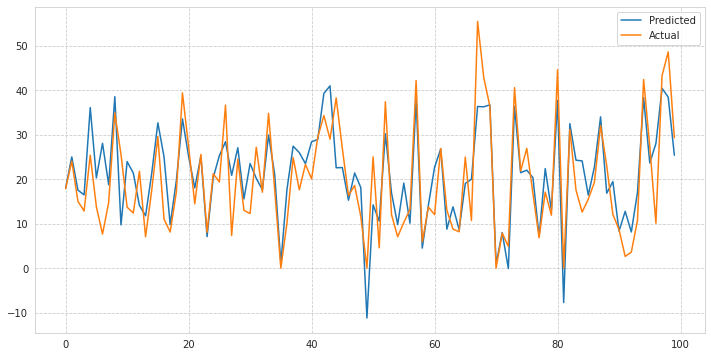

In [158]:
plt.figure(figsize=(12,6))
plt.plot(test_pred_en[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

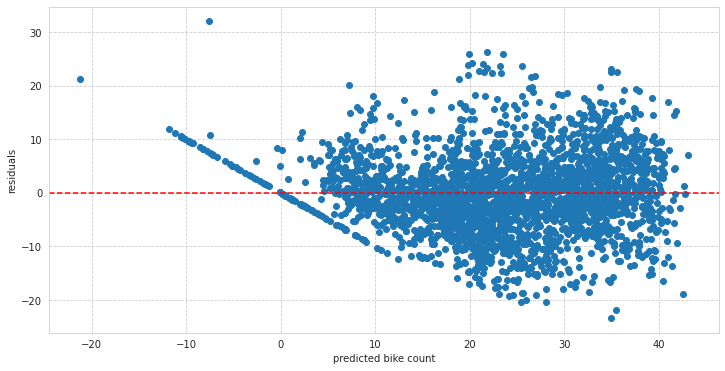

In [159]:
# Heteroskedasticity
plt.figure(figsize=(12,6))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_en, y_test- test_pred_en)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

## **DecisionTree Regressor**

In [160]:
# Hyperparameter grid 
dt_params = {"criterion": ["mse", "mae"],
             "max_depth": [4, 5, 6, 7, 8],
             "min_samples_split": [10, 20, 40],
             "min_samples_leaf": [20, 40, 100],
              }

In [161]:
# create an instance of DecisionTreeRegressor
dt_reg= DecisionTreeRegressor()

# GridSearch
dt_grid= GridSearchCV(estimator = dt_reg, param_grid = dt_params, cv = 5, verbose = 2)

dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=10; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=10; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=10; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=10; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=10; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=20; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=20; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=20; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_samples_leaf=20, min_samples_split=20; total time=   0.0s
[CV] END criterion=mse, max_depth=4, min_sample

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]},
             verbose=2)

In [162]:
# best parameters
dt_grid.best_params_

{'criterion': 'mse',
 'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 10}

In [163]:
dt_optimal_model= dt_grid.best_estimator_

In [164]:
# Model score
dt_optimal_model.score(X_train, y_train)

0.8613754775424959

In [165]:
# predictions on train and test data
train_pred_dt= dt_optimal_model.predict(X_train)
test_pred_dt= dt_optimal_model.predict(X_test)

### **Evaluation Metrics**

In [166]:
# train data evaluation metrics
evaluation_metrics(y_train, train_pred_dt)

MSE : 21.56339216605
RMSE : 4.643639969468994
MAE : 3.2189321708842793
 
R2 : 0.8613754775424959
Adjusted R2 :  0.8607393420665914


In [167]:
# test data evaluation metrics
evaluation_metrics(y_test, test_pred_dt)

MSE : 24.623417452837717
RMSE : 4.962198852609367
MAE : 3.4556336932227656
 
R2 : 0.8396892948185077
Adjusted R2 :  0.8389536433989369


In [168]:
# appending test results
test_result['DecisionTree Regressor']= [0.8613754775424959, 24.623417452837717, 4.962198852609367, 0.8396892948185077, 0.8389536433989369]

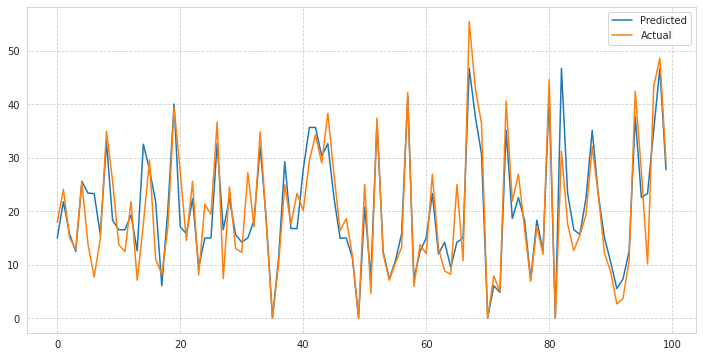

In [169]:
plt.figure(figsize=(12,6))
plt.plot(test_pred_dt[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

### **Feature Importance**

In [170]:
dt_optimal_model.feature_importances_

array([2.28746482e-01, 2.83530983e-01, 1.69522561e-01, 1.29193582e-04,
       4.96484172e-04, 3.60891331e-02, 1.91378840e-02, 1.44827097e-04,
       8.74705656e-02, 9.23499803e-04, 1.65381557e-01, 8.42683001e-03])

Create function to plot feature importance

In [179]:
def plot_feature_importance(model,X):

  ''' plots feature importance graph '''


  importances = list(model.feature_importances_)

  feature_importances= {'feature':list(X.columns), 'feature_importance':importances}

  importance_df= pd.DataFrame(feature_importances)
  importance_df.sort_values(by='feature_importance', ascending=False, inplace=True)

  plt.figure(figsize=(9,6))
  sns.barplot(x='feature_importance', y='feature', data=importance_df)
  
  plt.title('Feature Importance')
  plt.xlabel("Importance")
  plt.ylabel("Features")

  plt.show()

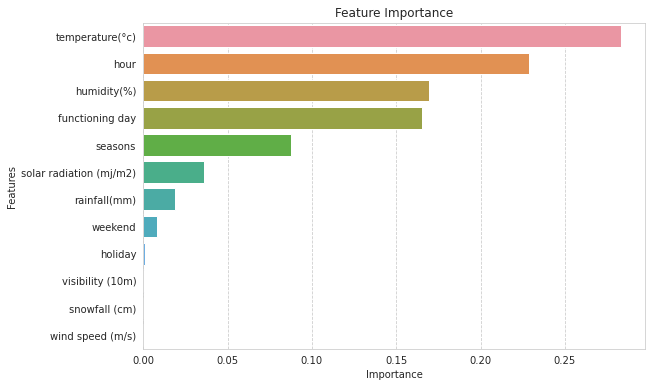

In [180]:
plot_feature_importance(dt_optimal_model,X)

# **Random Forest Regressor**

In [264]:
# hyperparameter grid
param_dict_rf = {
    'n_estimators': [50, 80, 100],
    'max_depth': [5, 6, 7],
    'min_samples_split': [50, 100, 150],
    'min_samples_leaf': [40, 50]
  }

In [265]:
# create regressor object
rf_model= RandomForestRegressor(random_state= 0)

# fitting gridsearch
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid = param_dict_rf,
                       cv = 5, verbose=2)

rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.6s
[CV] END max_depth=5, min_sam

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 6, 7], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             verbose=2)

In [266]:
# best parameters
rf_grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 40,
 'min_samples_split': 50,
 'n_estimators': 80}

In [267]:
# optimal model
rf_optimal_model= rf_grid.best_estimator_

In [268]:
# Model score
rf_optimal_model.score(X_train,y_train)

0.8525720640876161

In [269]:
# Making predictions on train and test data
train_pred_rf= rf_optimal_model.predict(X_train)
test_pred_rf= rf_optimal_model.predict(X_test)

### **Evaluation Metrics**

In [270]:
evaluation_metrics(y_train, train_pred_rf)

MSE : 22.932785209662818
RMSE : 4.788818769765966
MAE : 3.456580144743102
 
R2 : 0.8525720640876161
Adjusted R2 :  0.8518955305384962


In [271]:
evaluation_metrics(y_test, test_pred_rf)

MSE : 25.86714574154239
RMSE : 5.085975397260824
MAE : 3.673145936632156
 
R2 : 0.8315920045297693
Adjusted R2 :  0.8308191953727357


In [272]:
# appending test results
test_result['RandomForest Regressor']= [0.8525720640876161, 25.86714574154239, 5.085975397260824, 0.8315920045297693, 0.8308191953727357]

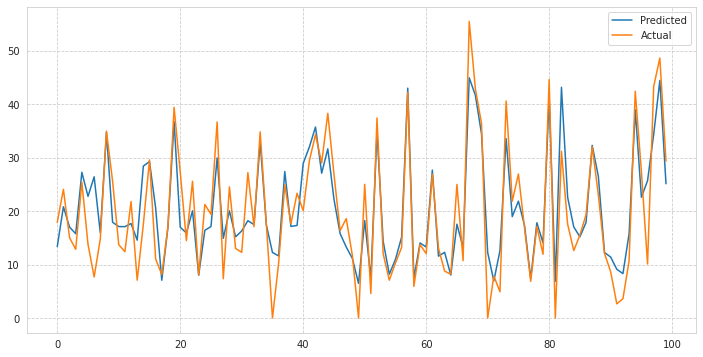

In [273]:
plt.figure(figsize=(12,6))
plt.plot(test_pred_rf[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

### **Feature Importances**

In [274]:
rf_optimal_model.feature_importances_

array([2.63044238e-01, 3.15298462e-01, 1.23894633e-01, 7.01979295e-04,
       2.18939472e-03, 2.97707704e-02, 5.05857417e-02, 4.97384186e-04,
       6.84735923e-02, 2.79031928e-04, 1.40384472e-01, 4.88030029e-03])

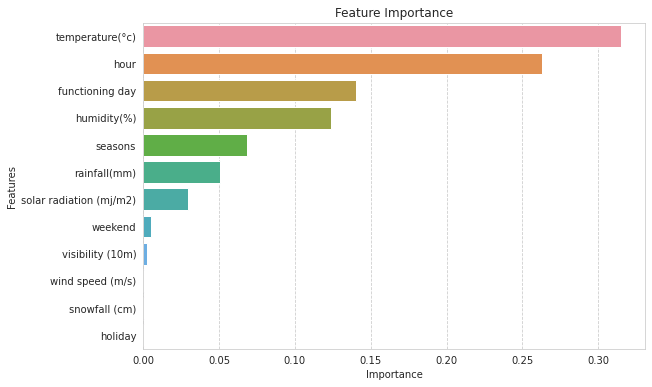

In [275]:
plot_feature_importance(rf_optimal_model,X)

# **Gradient Boosting Regressor**

In [216]:
from sklearn.ensemble import GradientBoostingRegressor

In [252]:
# HYperparameter Grid
param_gb = {'n_estimators' : [50, 100, 150],
              'max_depth' : [5, 6, 7],
              'min_samples_split' : [50, 80],
              'min_samples_leaf' : [40, 50]}

In [253]:
# Create an instance of the  GradientBoostingRegressor
gb_model=GradientBoostingRegressor()

# Grid search
gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid = param_gb,
                       cv = 3, verbose=2, scoring='neg_mean_squared_error')

gb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=150; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=150; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=150; total time=   1.1s
[CV] END max_depth=5, m

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [5, 6, 7], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 80],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [254]:
gb_grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 40,
 'min_samples_split': 50,
 'n_estimators': 150}

In [255]:
gb_optimal_model= gb_grid.best_estimator_

In [256]:
gb_optimal_model.score(X_train,y_train)

0.9646197487449791

In [257]:
train_pred_gb= gb_optimal_model.predict(X_train)
test_pred_gb= gb_optimal_model.predict(X_test)

### **Evaluation metrics**

In [258]:
evaluation_metrics(y_train,train_pred_gb)

MSE : 5.503486823402925
RMSE : 2.3459511553744945
MAE : 1.5712694834477356
 
R2 : 0.9646197487449791
Adjusted R2 :  0.9644573919514571


In [259]:
evaluation_metrics(y_test,test_pred_gb)

MSE : 10.444211162305
RMSE : 3.231750479586102
MAE : 2.1245569091265963
 
R2 : 0.932002986193918
Adjusted R2 :  0.9316909540081921


In [260]:
# appending test results
test_result['Gradient Boosting Regressor']= [0.9646197487449791, 10.444211162304999, 3.231750479586102, 0.932002986193918, 0.9316909540081921]

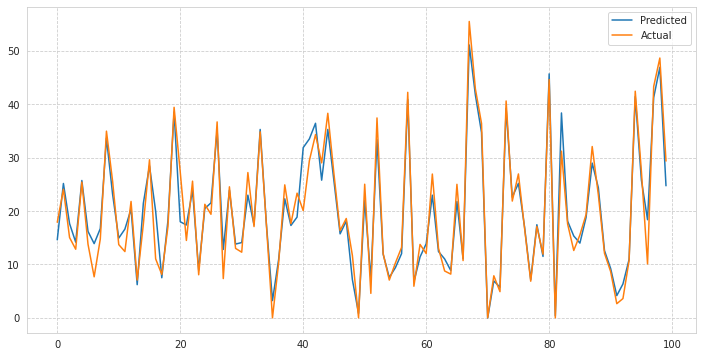

In [261]:
plt.figure(figsize=(12,6))
plt.plot(test_pred_xgb[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

### **Feature Importance**

In [262]:
gb_optimal_model.feature_importances_

array([0.2508707 , 0.28417915, 0.1189777 , 0.00325562, 0.00630607,
       0.0372712 , 0.05966394, 0.00115578, 0.06408842, 0.00220361,
       0.15248248, 0.01954532])

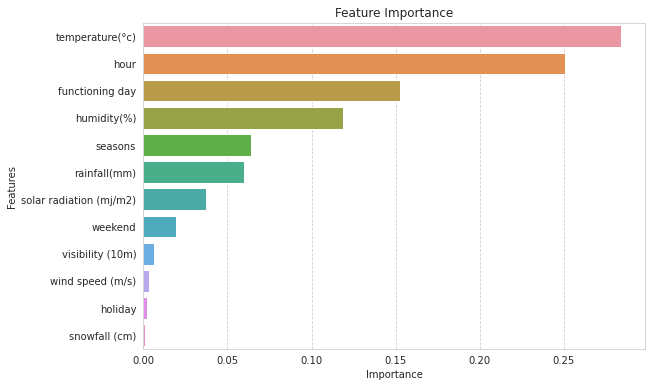

In [263]:
plot_feature_importance(gb_optimal_model,X)

# **XG Boost Regressor**

In [199]:
from xgboost import XGBRegressor

In [285]:
param_dict_xgb= {'max_depth': [4,5,6],
                 'learning_rate': [0.05, 0.1, 0.3],
                 'n_estimators': [50,100,150],
                 'colsample_bytree': [0.5,0.7],
                 'subsample': [0.6,0.7]
                }

In [286]:
# Creating an instance 
xgb_model = XGBRegressor()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid = param_dict_xgb,
                       cv = 3, scoring='neg_mean_squared_error', verbose=2)

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[14:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=50, subsample=0.6; total time=   0.1s
[14:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=50, subsample=0.6; total time=   0.1s
[14:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=50, subsample=0.6; total time=   0.1s
[14:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=4, n_estimators=50, sub

GridSearchCV(cv=3, estimator=XGBRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [4, 5, 6], 'n_estimators': [50, 100, 150],
                         'subsample': [0.6, 0.7]},
             scoring='neg_mean_squared_error', verbose=2)

In [287]:
# best parameters
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 150,
 'subsample': 0.7}

In [288]:
xgb_optimal_model= xgb_grid.best_estimator_

In [289]:
# Model score
xgb_optimal_model.score(X_train,y_train)

0.9747815243626602

In [290]:
# Making predictions on train and test data
train_pred_xgb= xgb_optimal_model.predict(X_train)
test_pred_xgb= xgb_optimal_model.predict(X_test)

### **Evaluation Metrics**

In [291]:
# Train data evaluation metrics
evaluation_metrics(y_train, train_pred_xgb)

MSE : 3.9227971383247824
RMSE : 1.9806052454552328
MAE : 1.3904262828789296
 
R2 : 0.9747815243626602
Adjusted R2 :  0.9746657990442479


In [292]:
# Test data evaluation metrics
evaluation_metrics(y_test, test_pred_xgb)

MSE : 9.89138188658586
RMSE : 3.1450567382140915
MAE : 2.1124345688077444
 
R2 : 0.9356021799778538
Adjusted R2 :  0.9353066641689567


In [293]:
# appending test results
test_result['XGBoost Regressor']= [0.9747815243626602, 9.89138188658586, 3.1450567382140915, 0.9356021799778538, 0.9353066641689567]

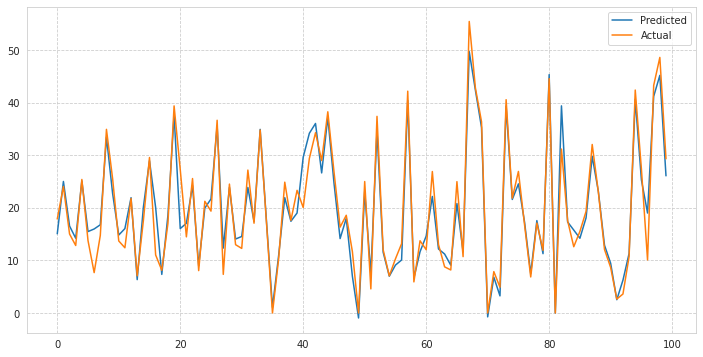

In [294]:
plt.figure(figsize=(12,6))
plt.plot(test_pred_xgb[:100])
plt.plot(np.array(y_test)[:100])
plt.legend(["Predicted","Actual"])
plt.show()

### **Feature Importances**

In [295]:
xgb_optimal_model.feature_importances_

array([0.09155758, 0.08042758, 0.04445084, 0.00468111, 0.00556637,
       0.02498387, 0.07957881, 0.0087659 , 0.1162655 , 0.01646329,
       0.48717362, 0.04008556], dtype=float32)

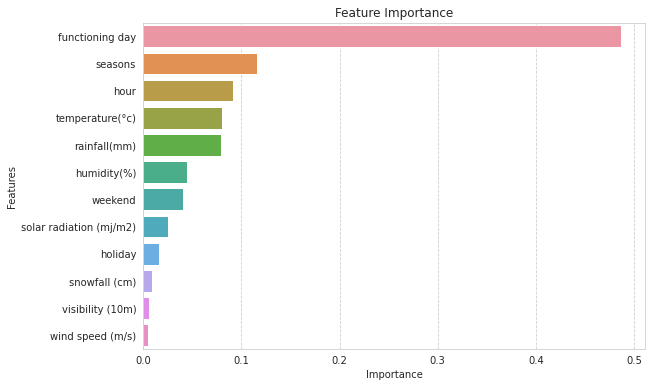

In [296]:
plot_feature_importance(xgb_optimal_model,X)

# **Test Results**

In [302]:
results_df= pd.DataFrame(test_result).T
results_df.columns= ['Model score', 'MSE', 'RMSE', 'R2 score', 'Adjusted R2']

In [303]:
results_df

,Model score,MSE,RMSE,R2 score,Adjusted R2
Linear Regression,0.654097,53.740491,7.330791,0.650123,0.648517
Lasso Regression,0.654097,53.740167,7.330769,0.650125,0.648519
Ridge Regression,0.654097,53.740491,7.330791,0.650123,0.648517
ElasticNet Regression,0.654097,53.740491,7.330791,0.650123,0.648517
DecisionTree Regressor,0.862696,24.616288,4.961480,0.839736,0.839000
RandomForest Regressor,0.852572,25.867146,5.085975,0.831592,0.830819
XGBoost Regressor,0.974782,9.891382,3.145057,0.935602,0.935307
Gradient Boosting Regressor,0.964620,10.444211,3.231750,0.932003,0.931691
